In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import utils
from yieldcurve import YieldCurve
import cashflow as cf

In [2]:
portfolio, market = utils.load_data()
TODAY = utils.set_today()
portfolio

,account,account_name,volume,ir_binding,reprice_freq,spread,issue,maturity,repayment,payment_freq,yieldcurve
id,,,,,,,,,,,
1,cb_1,Cash and balances with central bank,930,FIX,1,5,2014-09-30,2014-10-01,BULLET,1,EUR01
2,mmp_1,Money market placements,1404,FIX,1,7,2014-08-30,2014-11-30,BULLET,1,EUR01
3,mmp_1,Money market placements,996,FIX,1,10,2014-06-15,2014-12-15,BULLET,1,EUR01
4,cl_1,Corporate loans,515,LIBOR,3,301,2014-05-15,2016-04-15,LINEAR,3,EUR01
5,cl_1,Corporate loans,655,LIBOR,6,414,2014-04-15,2016-04-15,LINEAR,6,EUR01
...,...,...,...,...,...,...,...,...,...,...,...
143,ret_td_1,Retail term deposit,-1229,FIX,1,48,2014-03-30,2015-08-30,BULLET,1,EUR01
144,ret_td_1,Retail term deposit,-2452,FIX,1,40,2014-02-28,2015-02-28,BULLET,1,EUR01
145,ret_td_1,Retail term deposit,-976,FIX,1,40,2014-01-28,2015-01-28,BULLET,1,EUR01


In [3]:
volume = 7500
maturity = 3
rate = 0.01
display(cf.amortization_schedule(rate, maturity, volume, payment_type="BULLET"))
display(cf.amortization_schedule(rate, maturity, volume, payment_type='LINEAR'))
display(cf.amortization_schedule(rate, maturity, volume, payment_type='ANNUITY'))

,cashflow,interest,capital,remaining
0,75.0,75.0,0.0,7500.0
1,75.0,75.0,0.0,7500.0
2,7575.0,75.0,7500.0,0.0


,cashflow,interest,capital,remaining
0,2575.0,75.0,2500.0,7500.0
1,2550.0,50.0,2500.0,5000.0
2,2525.0,25.0,2500.0,2500.0


,cashflow,interest,capital,remaining
0,1922.108204,75.000000,1847.108204,5652.891796
1,1922.108204,56.528918,1865.579286,3787.312509
2,1922.108204,37.873125,1884.235079,1903.077430


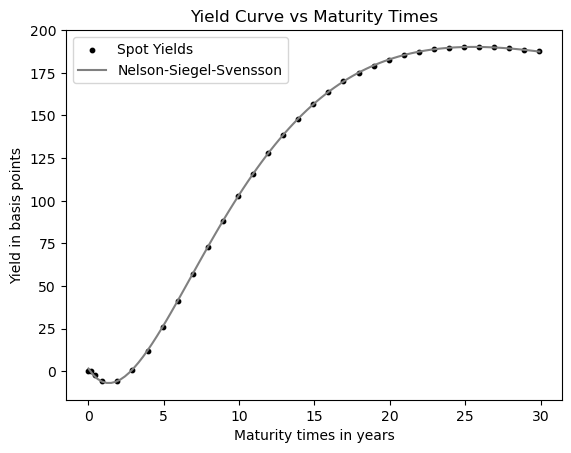

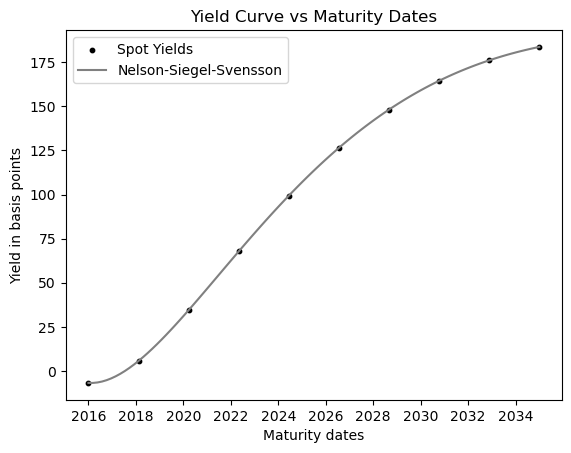

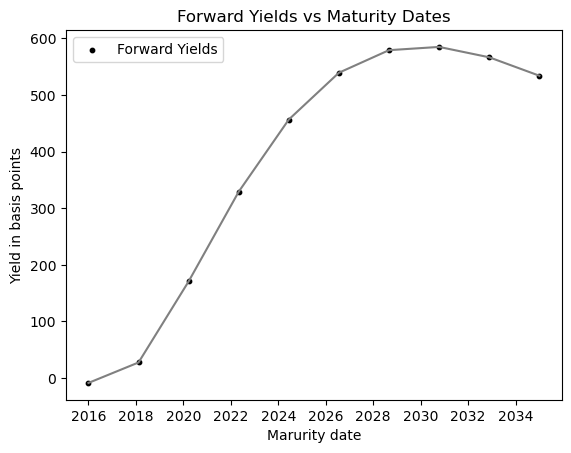

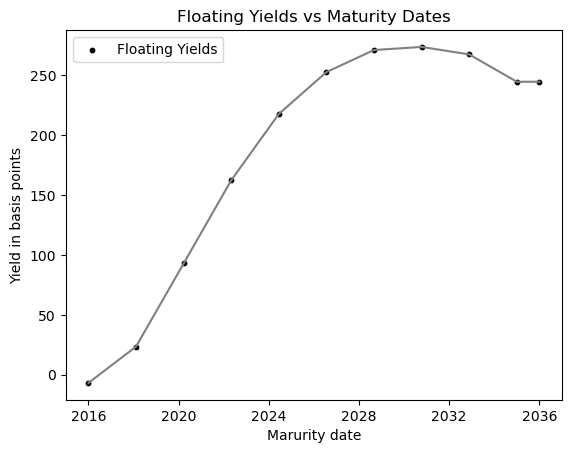

In [4]:
plot = True
EUR01 = YieldCurve(curve_type='EUR01', today=TODAY)
EUR01.fit(market, plot=plot)
date_list = utils.date_range('2016-01-01', '2035-01-01', 10)
spot_yields = EUR01.get_spot_yields(date_list, plot=plot)
forward_yields = EUR01.get_forward_yields(date_list, plot=plot)

date_list1 = utils.date_range('2016-01-01', '2035-01-01', 20)
date_list2 = utils.date_range('2016-01-01', '2035-01-01',10)
date_list2.append(datetime(2036,1,1))
floating_yields = EUR01.get_floating_yields(repayment_dates = date_list2, repricing_dates = date_list1, plot=plot)

In [5]:
display(portfolio.loc[10])
cf.asset_cashflow(portfolio, market, 10, TODAY)

account                        cl_1
account_name        Corporate loans
volume                          463
ir_binding                    LIBOR
reprice_freq                      3
spread                          332
issue           2013-11-15 00:00:00
maturity        2016-01-15 00:00:00
repayment                    LINEAR
payment_freq                      3
yieldcurve                    EUR01
Name: 10, dtype: object

,id,account,date,cashflow,interest,capital,remaining
0,10,cl_1,2014-10-15,81.010398,3.843732,77.166667,463.000000
1,10,cl_1,2015-01-15,80.369171,3.202504,77.166667,385.833333
2,10,cl_1,2015-04-15,79.720968,2.554301,77.166667,308.666667
3,10,cl_1,2015-07-15,79.077568,1.910901,77.166667,231.500000
4,10,cl_1,2015-10-15,78.438704,1.272038,77.166667,154.333333
5,10,cl_1,2016-01-15,77.802656,0.635989,77.166667,77.166667


In [6]:
portfolio_cashflow = cf.portfolio_cashflow(portfolio, market, TODAY)

In [7]:
cf.get_present_values(cashflows=portfolio_cashflow, market=market, today=TODAY)

,account,date,present_values
id,,,
1,cb_1,2014-09-30,930.038331
2,mmp_1,2014-09-30,1404.173476
3,mmp_1,2014-09-30,996.267185
4,cl_1,2014-09-30,530.700425
5,cl_1,2014-09-30,689.098535
...,...,...,...
143,ret_td_1,2014-09-30,-1235.085747
144,ret_td_1,2014-09-30,-2456.382170
145,ret_td_1,2014-09-30,-977.369632


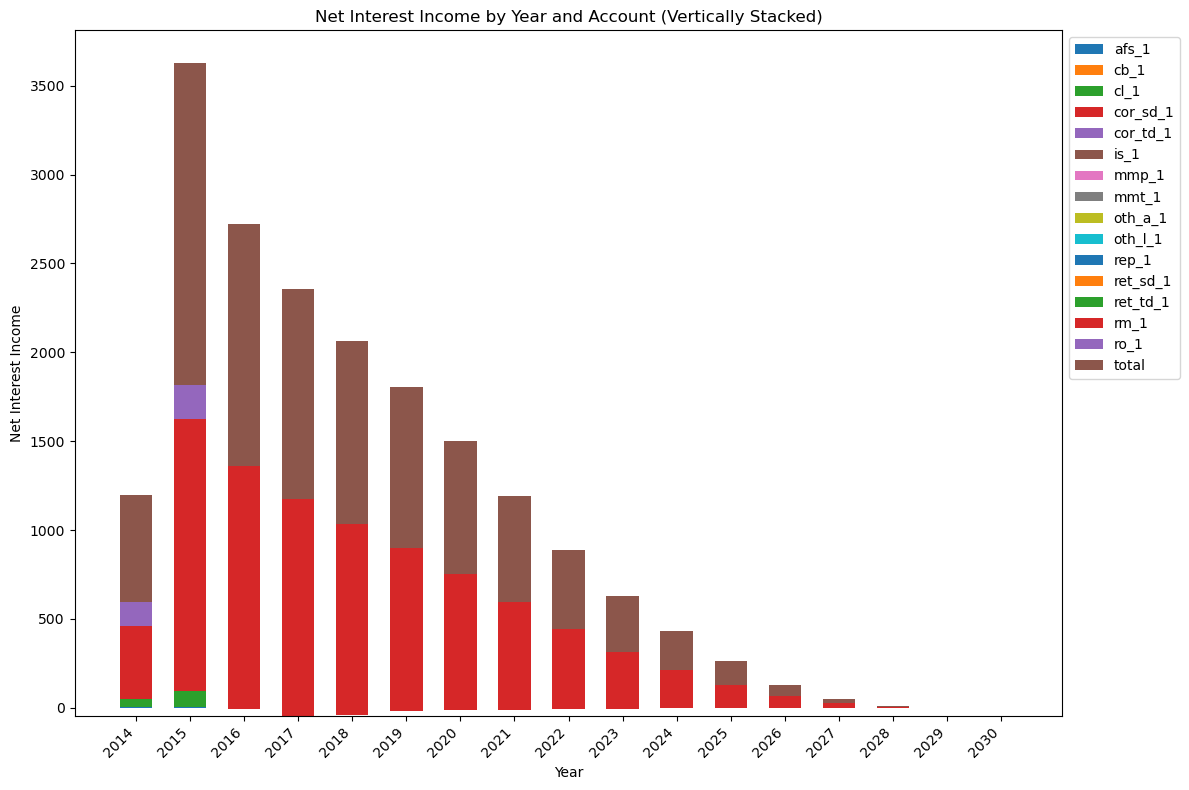

year,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
account,,,,,,,,,,,,,,,,,
afs_1,6.988700,3.421667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
cb_1,0.038750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
cl_1,98.649849,230.729833,95.198928,34.657340,3.547923,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
cor_sd_1,-3.195833,-11.158333,-8.558333,-5.958333,-3.358333,-0.812500,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
cor_td_1,-5.596625,-1.993675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
is_1,-26.190199,-80.225486,-65.817673,-48.814757,-22.200196,-1.995362,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
mmp_1,0.412800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
mmt_1,-0.774925,-1.552539,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
oth_a_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0


In [15]:
nii = cf.nii_table(portfolio_cashflow, today=TODAY, plot=True)
display(nii)

In [9]:
cf.repricing_gap(portfolio, 11, TODAY, 13)

,volume
1,332
2,0
3,0
4,0
5,0
6,0
7,332
8,0
9,0
10,0


,1M,2M,3M,4M,5M,6M,7M,8M,9M,10M,11M,12M
volume,6100.0,9283.0,725.0,1787.0,7115.0,6560.0,1921.0,5919.0,2009.0,8649.0,6855.0,2730.0


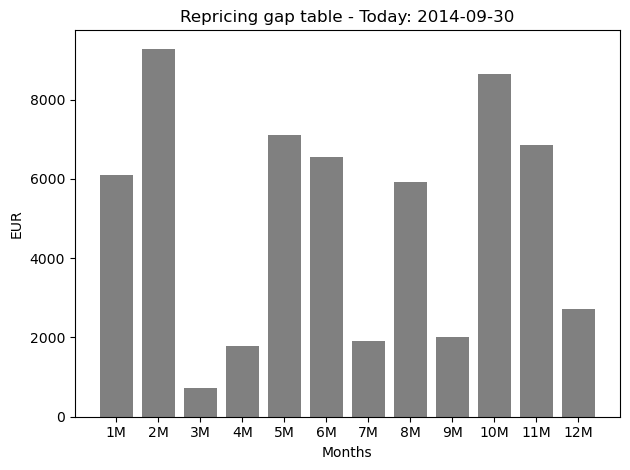

In [14]:
cf.repricing_gap_table(portfolio, today=TODAY, months_forward=12, plot=True)